<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Aprendizaje%20Supervisado/Classification/wine_classification_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación por tipo de vino, parte 2

## Datos sobre el vino
Datos de http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citas
<pre>
Dua, D. y Karra Taniskidou, E. (2017). 
UCI Machine Learning Repository [http://archive.ics.uci.edu/ml/index.php]. 
Irvine, CA: Universidad de California, Escuela de Ciencias de la Información y Computación.
</pre>

<pre>
P. Cortez, A. Cerdeira, F. Almeida, T. Matos y J. Reis. 
Modelización de las preferencias del vino mediante minería de datos a partir de las propiedades fisicoquímicas.
En Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
</pre>

Disponible en:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

## Configuración

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

red_wine = pd.read_csv('data/winequality-red.csv')
white_wine = pd.read_csv('data/winequality-white.csv', sep=';')
wine = pd.concat([
    white_wine.assign(kind='white'), red_wine.assign(kind='red')
])

In [ ]:
wine.sample(5, random_state=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kind
848,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,9.8,5,red
2529,6.6,0.42,0.13,12.8,0.044,26.0,158.0,0.99772,3.24,0.47,9.0,5,white
131,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,red
244,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red
1551,6.6,0.19,0.99,1.2,0.122,45.0,129.0,0.99360,3.09,0.31,8.7,6,white


## Train Test Split
Al igual que en el capítulo 9, intentaremos predecir si un vino es tinto o blanco basándonos en sus propiedades químicas:

In [ ]:
from sklearn.model_selection import train_test_split

wine_y = np.where(wine.kind == 'red', 1, 0)
wine_X = wine.drop(columns=['quality', 'kind'])

w_X_train, w_X_test, w_y_train, w_y_test = train_test_split(
    wine_X, wine_y, test_size=0.25, random_state=0, stratify=wine_y
)

## Clasificación por regresión logística de los vinos tintos y blancos

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

white_or_red = Pipeline([
    ('scale', StandardScaler()), 
    ('lr', LogisticRegression(random_state=0))
]).fit(w_X_train, w_y_train)

kind_preds = white_or_red.predict(w_X_test)

El modelo funcionó muy bien sin ningún tipo de ajuste:

In [ ]:
from sklearn.metrics import classification_report
print(f'Classification Report: \n{classification_report(w_y_test, kind_preds)}')

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1225
           1       0.99      0.98      0.98       400

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



<AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)'>

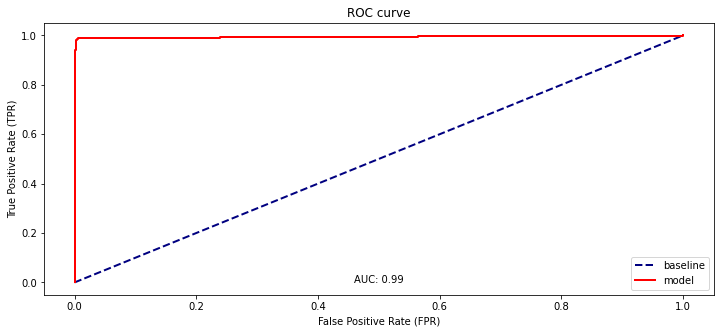

In [ ]:
from ml_utils.classification import plot_roc
plt.rc('figure', figsize=(12, 5))

plot_roc(w_y_test, white_or_red.predict_proba(w_X_test)[:,1])

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

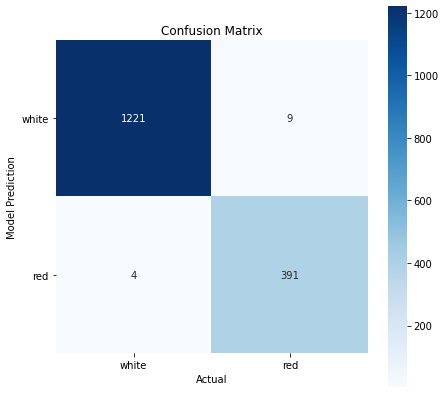

In [ ]:
from ml_utils.classification import confusion_matrix_visual
plt.rc('figure', figsize=(7,7))

confusion_matrix_visual(w_y_test, kind_preds, ['white', 'red'])

## Reducción de la Dimensionalidad
### Umbral de varianza
Las características con poca o ninguna varianza no contribuyen mucho a nuestro modelo de clasificación. Podemos eliminarlas y trabajar con las características que tienen alguna varianza. Por defecto, la clase `VarianceThreshold` eliminará todas las características que tengan el mismo valor en todo el conjunto de datos:

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

white_or_red_min_var = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0.01)), # mantener las características con varianza > 0,01
    ('scale', StandardScaler()), 
    ('lr', LogisticRegression(random_state=0))
]).fit(w_X_train, w_y_train)

Comprueba qué características se han eliminado:

In [ ]:
w_X_train.columns[
    ~white_or_red_min_var.named_steps[
        'feature_selection'
    ].get_support()
]

Index(['chlorides', 'density'], dtype='object')

El rendimiento no cambia mucho cuando se utilizan sólo 9 de las 11 funciones:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(w_y_test, white_or_red_min_var.predict(w_X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1225
           1       0.98      0.95      0.96       400

    accuracy                           0.98      1625
   macro avg       0.98      0.97      0.97      1625
weighted avg       0.98      0.98      0.98      1625



### Análisis de Componentes Principales
¿Podemos ver una forma de separarlas fácilmente que pueda ayudarnos?

Text(0.5, 1.0, 'Wine Kind PCA (2 components)')

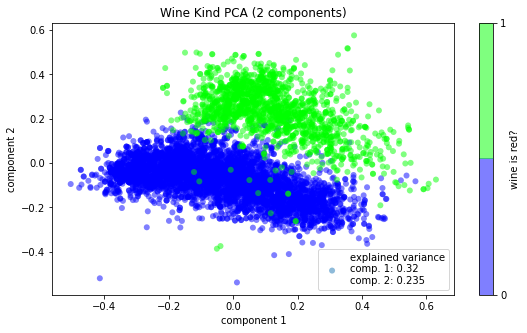

In [ ]:
from ml_utils.pca import pca_scatter
plt.rc('figure', figsize=(9, 5))

pca_scatter(wine_X, wine_y, 'wine is red?')
plt.title('Wine Kind PCA (2 components)')

Text(0.5, 0.98, 'Wine Type PCA (3 components)')

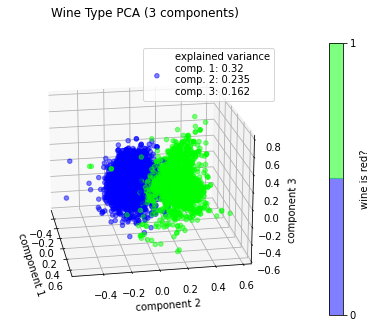

In [ ]:
from ml_utils.pca import pca_scatter_3d
plt.rc('figure', figsize=(9, 5))

pca_scatter_3d(wine_X, wine_y, 'wine is red?', elev=20, azim=-10)
plt.suptitle('Wine Type PCA (3 components)')

¿Cuántos componentes del PCA explican la mayor parte de la varianza?

<AxesSubplot:title={'center':'Total Explained Variance Ratio for PCA Components'}, xlabel='PCA components used', ylabel='cumulative explained variance ratio'>

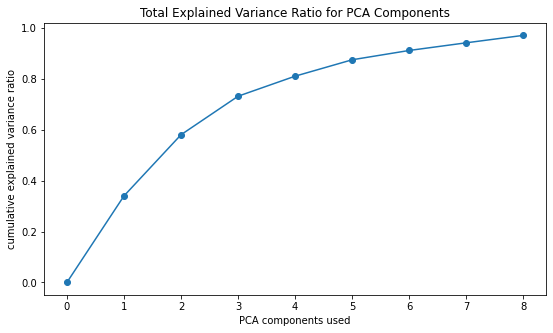

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from ml_utils.pca import pca_explained_variance_plot

pipeline = Pipeline([
    ('normalize', MinMaxScaler()), ('pca', PCA(8, random_state=0))
]).fit(w_X_train, w_y_train) 

plt.rc('figure', figsize=(9, 5))
pca_explained_variance_plot(pipeline.named_steps['pca'])

Utilización de un diagrama de dispersión para encontrar el número de componentes a utilizar.

<AxesSubplot:title={'center':'Scree Plot for PCA Components'}, xlabel='component', ylabel='explained variance'>

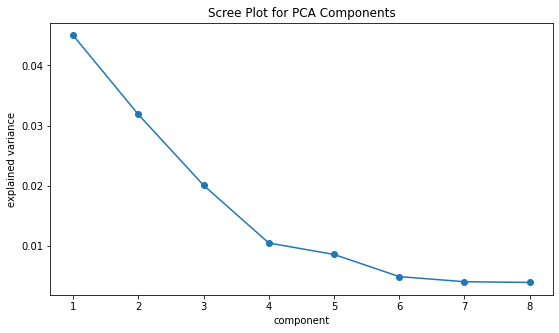

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from ml_utils.pca import pca_scree_plot

pipeline = Pipeline([
    ('normalize', MinMaxScaler()), ('pca', PCA(8, random_state=0))
]).fit(w_X_train, w_y_train)

plt.rc('figure', figsize=(9, 5))
pca_scree_plot(pipeline.named_steps['pca'])

### ¿Un modelo ajustado a estos componentes tendrá mejores resultados?

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('normalize', MinMaxScaler()),
    ('pca', PCA(4, random_state=0)),
    ('lr', LogisticRegression(
        class_weight='balanced', random_state=0
    ))
]).fit(w_X_train, w_y_train)

Observe que sólo tenemos 4 características (nuestros componentes PCA):

In [ ]:
pipeline.named_steps['lr'].coef_

array([[ 4.69231352, 19.27678507,  2.2161272 , -4.0772633 ]])

Compruebe la concordancia entre nuestro nuevo modelo y el original:

In [ ]:
# acuerdo con la regresión logística sola
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(kind_preds, pipeline.predict(w_X_test))

0.9633975284373049

El rendimiento sigue siendo bueno utilizando la reducción de la dimensionalidad:

In [ ]:
from sklearn.metrics import classification_report

preds = pipeline.predict(w_X_test)
print(classification_report(w_y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1225
           1       0.96      0.96      0.96       400

    accuracy                           0.98      1625
   macro avg       0.98      0.98      0.98      1625
weighted avg       0.98      0.98      0.98      1625



<AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)'>

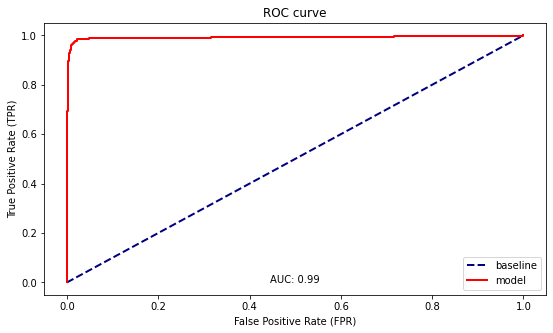

In [ ]:
from ml_utils.classification import plot_roc

plt.rc('figure', figsize=(9, 5))
plot_roc(w_y_test, pipeline.predict_proba(w_X_test)[:,1])

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

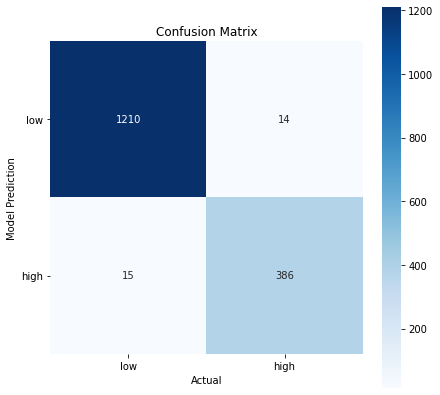

In [ ]:
from ml_utils.classification import confusion_matrix_visual

plt.rc('figure', figsize=(7, 7))
confusion_matrix_visual(w_y_test, preds, ['low', 'high'])

## ¿Puede un árbol de decisión decirnos qué características son importantes?
Los árboles de decisión nos dan la importancia de las características. Estas suman 1, siendo la más alta la más importante.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0).fit(w_X_train, w_y_train)
pd.DataFrame([(col, coef) for col, coef in zip(
    w_X_train.columns, dt.feature_importances_
)], columns=['feature', 'importance']
).set_index('feature').sort_values(
    'importance', ascending=False
).T

feature,total sulfur dioxide,chlorides,density,volatile acidity,sulphates,pH,residual sugar,alcohol,fixed acidity,citric acid,free sulfur dioxide
importance,0.687236,0.210241,0.050201,0.016196,0.012143,0.01143,0.005513,0.005074,0.001811,0.000113,0.000042


### Visualización de las 2 características principales
Observando las 2 características principales, podemos ver si es posible separar el vino tinto del blanco:

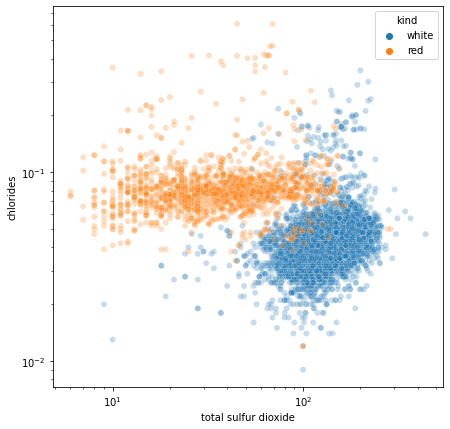

In [ ]:
sns.scatterplot(x=wine['total sulfur dioxide'], y=wine['chlorides'], hue=wine.kind, alpha=0.25, sizes=(7,5))
plt.xscale('log')
plt.yscale('log')

### Uso de las 2 características principales para la clasificación de los vinos tintos y blancos
Podemos construir un modelo sólo con estas características:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

important_features = ['total sulfur dioxide', 'chlorides']
X_train = w_X_train[important_features]
X_test = w_X_test[important_features]

white_or_red_top_features = Pipeline([
    ('scale', StandardScaler()), 
    ('lr', LogisticRegression(random_state=0))
]).fit(X_train, w_y_train)

top_features_kind_preds = white_or_red_top_features.predict(X_test)

Fíjate en que nuestro rendimiento sigue siendo bueno:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(w_y_test, top_features_kind_preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1225
           1       0.94      0.85      0.90       400

    accuracy                           0.95      1625
   macro avg       0.95      0.92      0.93      1625
weighted avg       0.95      0.95      0.95      1625



<AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)'>

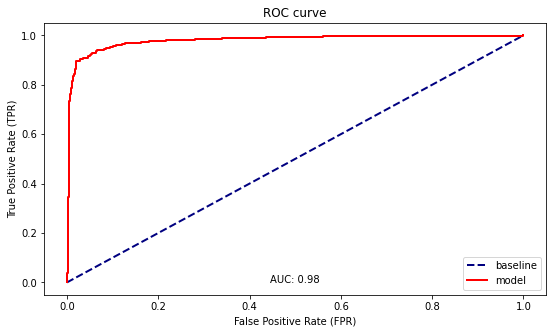

In [ ]:
from ml_utils.classification import plot_roc

plt.rc('figure', figsize=(9, 5))
plot_roc(w_y_test, white_or_red_top_features.predict_proba(X_test)[:,1])

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

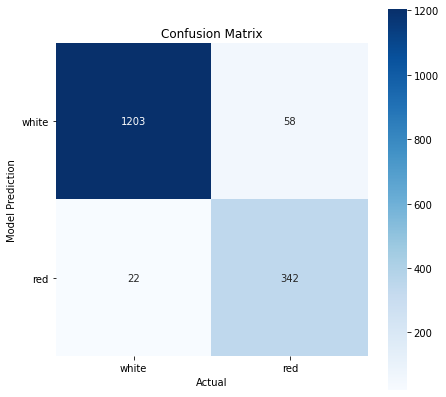

In [ ]:
from ml_utils.classification import confusion_matrix_visual

plt.rc('figure', figsize=(7, 7))
confusion_matrix_visual(w_y_test, top_features_kind_preds, ['white', 'red'])

### Visualización del árbol de decisión
También podemos visualizar las decisiones que ha tomado el árbol:

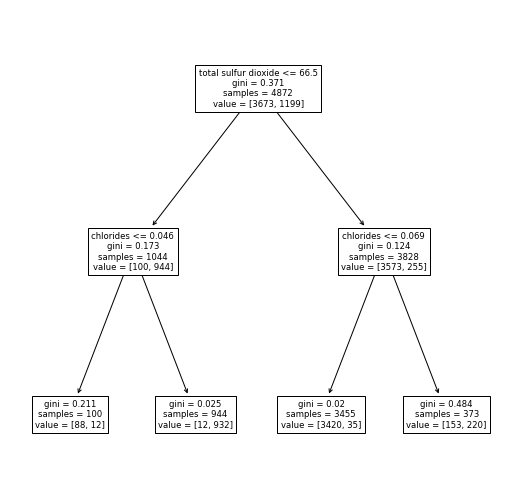

In [ ]:
from sklearn.tree import plot_tree


plt.rc('figure', figsize=(9, 9))

plot_tree(
    DecisionTreeClassifier(
        max_depth=2, random_state=0
    ).fit(w_X_train, w_y_train),
    feature_names=w_X_train.columns
);

## Análisis de errores en la regresión logística
Podemos observar las predicciones incorrectas para tener una mejor idea de nuestros datos y del modelo:

In [ ]:
prediction_probabilities = pd.DataFrame(
    white_or_red.predict_proba(w_X_test), 
    columns=['prob_white', 'prob_red']
).assign(
    is_red=w_y_test == 1,
    pred_white=lambda x: x.prob_white >= 0.5, 
    pred_red=lambda x: np.invert(x.pred_white),
    correct=lambda x: (np.invert(x.is_red) & x.pred_white)
                       | (x.is_red & x.pred_red)
)

prediction_probabilities.sample(5, random_state=0)

,prob_white,prob_red,is_red,pred_white,pred_red,correct
443,0.994654,0.005346,False,True,False,True
319,0.999605,0.000395,False,True,False,True
703,0.000326,0.999674,True,False,True,True
526,0.999278,0.000722,False,True,False,True
76,0.999683,0.000317,False,True,False,True


### Distribución de la confianza en la predicción
Cuando nuestro modelo tiene confianza, suele acertar:

Text(0.5, 1.05, 'Confianza en la predicción')

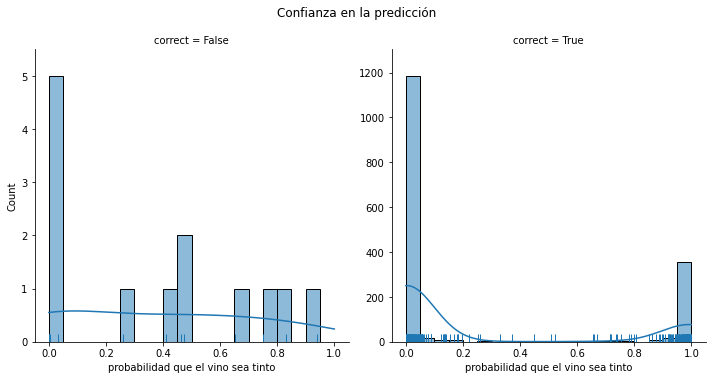

In [ ]:
g = sns.displot(
    data=prediction_probabilities, x='prob_red',
    rug=True, kde=True, bins=20, col='correct', 
    facet_kws={'sharey': False}
)
g.set_axis_labels('probabilidad que el vino sea tinto', None)
plt.suptitle('Confianza en la predicción', y=1.05)

### ¿Son las clasificaciones incorrectas valores atípicos?

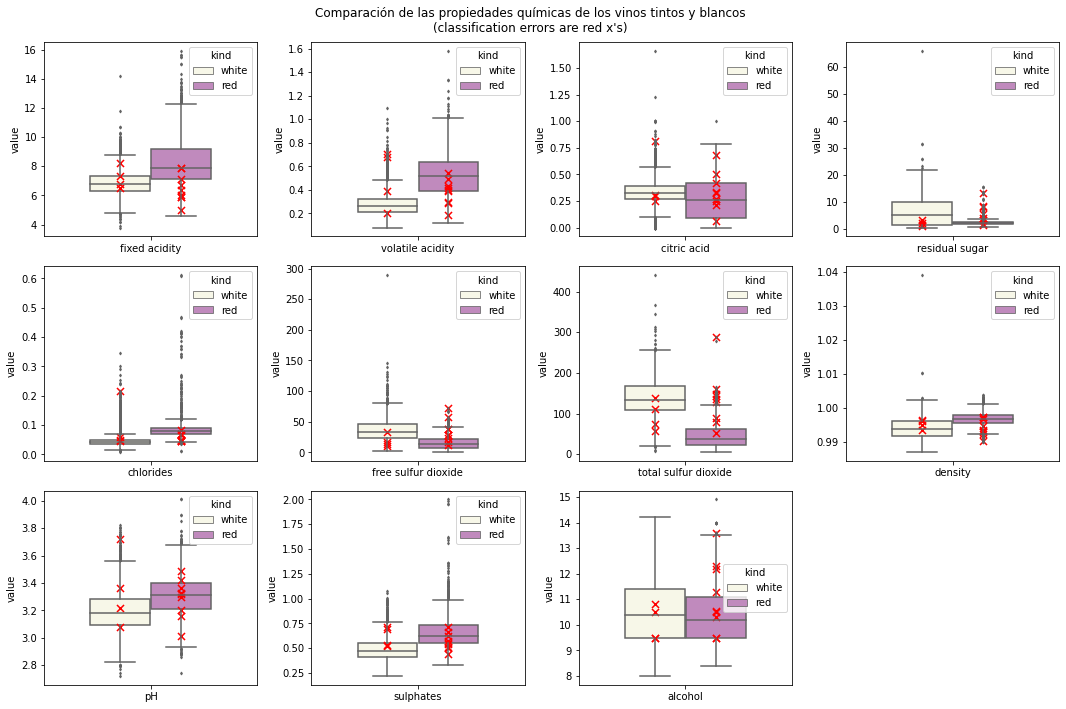

In [ ]:
import math

incorrect = w_X_test.assign(is_red=w_y_test).iloc[prediction_probabilities.query('not correct').index]
chemical_properties = [col for col in wine.columns if col not in ['quality', 'kind']]
melted = wine.drop(columns='quality').melt(id_vars=['kind'])

fig, axes = plt.subplots(math.ceil(len(chemical_properties) / 4), 4, figsize=(15, 10))
axes = axes.flatten()

for prop, ax in zip(chemical_properties, axes):
    sns.boxplot(
        data=melted[melted.variable.isin([prop])], 
        x='variable', y='value', hue='kind', ax=ax,
        palette={'white': 'lightyellow', 'red': 'orchid'}, 
        saturation=0.5, fliersize=2
    ).set_xlabel('')
    for _, wrong in incorrect.iterrows():
        x_coord = -0.2 if not wrong['is_red'] else 0.2
        ax.scatter(x_coord, wrong[prop], marker='x', color='red', s=50)
    
# remove the extra subplots
for ax in axes[len(chemical_properties):]:
    ax.remove()
    
plt.suptitle(
    'Comparación de las propiedades químicas de los vinos tintos y blancos'
    '\n(classification errors are red x\'s)'
)
plt.tight_layout()